# Eigenfunctions of the Koopman operator

**Adapted from**: Example 2.6 of [MAI20]

[MAI20] Mauroy, Alexandre, Aivar Sootla, and Igor Mezić.
*Koopman framework for global stability analysis.*
The Koopman Operator in Systems and Control: Concepts, Methodologies, and Applications (2020): 35-58.

In [1]:
using DynamicPolynomials
@polyvar x[1:2]

a = 1
I = 0.05
ε = 0.08
γ = 1
F0 = [-x[2] - x[1] * (x[1] - 1) * (x[1] - a) + I, ε * (x[1] - γ * x[2])]

2-element Vector{DynamicPolynomials.Polynomial{true, Float64}}:
 -x₁³ + 2.0x₁² - x₁ - x₂ + 0.05
 0.08x₁ - 0.08x₂

We move equilibrium `(0.0256, 0.0256)` to the origin

In [2]:
x1 = x2 = 0.0256
F = [f(x => [x[1] + x1, x[2] + x2]) for f in F0]

2-element Vector{DynamicPolynomials.Polynomial{true, Float64}}:
 -x₁³ + 1.9232x₁² - 0.89956608x₁ - x₂ + 9.394278400000344e-5
 0.08x₁ - 0.08x₂

We compute the Jacobian at the equilibrium

In [3]:
J = [j(x => zeros(2)) for j in differentiate(F, x)]

2×2 Matrix{Float64}:
 -0.899566  -1.0
  0.08      -0.08

We see that its eigenvalues indeed have negative real part:

In [4]:
using LinearAlgebra
E = eigen(J)

LinearAlgebra.Eigen{Float64, Float64, Matrix{Float64}, Vector{Float64}}
values:
2-element Vector{Float64}:
 -0.7862997172234601
 -0.1932663627765399
vectors:
2×2 Matrix{Float64}:
 -0.993646   0.816807
  0.112547  -0.576911

We set `w` as its dominant eigenvector:

In [5]:
λ = E.values[end]
w = E.vectors[:, end]

using SumOfSquares
r = 0.3
X = @set x[1]^2 + x[2]^2 ≤ r^2

Basic semialgebraic Set defined by no equality
1 inequalitty
 -x[1]^2 - x[2]^2 + 0.09 ≥ 0


We define the the program for the FitzHugh-Nagumo problem below:
`N` is the degree of `ϕN` as defined in [MAI20, p. 50] and `M` is the
degree of the multipliers for the constraints of `X`.
As `maxdegree` corresponds to the degree of the multiplier multiplied
by `r^2 - x[1]^2 - x[2]^2`, we set it to `M + 2`.

In [6]:
function fitzhugh_nagumo(solver, N, M)
    model = SOSModel(solver)
    @variable(model, γ)
    @objective(model, Min, γ)
    @variable(model, ϕN, Poly(monomials(x, 2:N)))
    ϕ = w ⋅ x + ϕN
    ∇ϕ = differentiate(ϕ, x)
    @constraint(model, -γ ≤ F ⋅ ∇ϕ - λ * ϕ, domain = X, maxdegree = M + 2)
    @constraint(model, F ⋅ ∇ϕ - λ * ϕ ≤ γ, domain = X, maxdegree = M + 2)
    optimize!(model)
    return ϕ, model
end

fitzhugh_nagumo (generic function with 1 method)

In [MAI20, p. 50], we read that the result is obtained with `N = 10` and
`M = 20`.

In [7]:
import CSDP
ϕ, model = fitzhugh_nagumo(CSDP.Optimizer, 10, 20)
solution_summary(model)

CSDP 6.2.0
Iter:  0 Ap: 0.00e+00 Pobj:  0.0000000e+00 Ad: 0.00e+00 Dobj:  0.0000000e+00 
Iter:  1 Ap: 1.00e+00 Pobj: -2.6021900e+01 Ad: 5.65e-01 Dobj: -1.1305988e-01 
Iter:  2 Ap: 1.00e+00 Pobj: -2.6827959e+01 Ad: 9.45e-01 Dobj: -4.4024766e-03 
Iter:  3 Ap: 1.00e+00 Pobj: -1.7660414e+01 Ad: 9.03e-01 Dobj: -4.7338901e-03 
Iter:  4 Ap: 1.00e+00 Pobj: -7.4183642e+00 Ad: 8.13e-01 Dobj: -7.1099873e-03 
Iter:  5 Ap: 1.00e+00 Pobj: -1.0428268e+00 Ad: 9.14e-01 Dobj: -1.3145696e-02 
Iter:  6 Ap: 9.96e-01 Pobj: -2.5785753e-01 Ad: 9.34e-01 Dobj: -1.6857373e-02 
Iter:  7 Ap: 8.27e-01 Pobj: -1.1381779e-01 Ad: 7.34e-01 Dobj: -3.9139550e-02 
Iter:  8 Ap: 8.54e-01 Pobj: -8.1907180e-02 Ad: 5.98e-01 Dobj: -5.4351801e-02 
Iter:  9 Ap: 8.49e-01 Pobj: -7.1609567e-02 Ad: 7.90e-01 Dobj: -5.7785524e-02 
Iter: 10 Ap: 5.71e-01 Pobj: -6.6022077e-02 Ad: 6.05e-01 Dobj: -5.9561421e-02 
Iter: 11 Ap: 3.86e-01 Pobj: -6.1121872e-02 Ad: 3.80e-01 Dobj: -5.8880926e-02 
Iter: 12 Ap: 3.90e-01 Pobj: -5.7449000e-02 Ad: 4.35e-

* Solver : CSDP

* Status
  Result count       : 1
  Termination status : ALMOST_OPTIMAL
  Message from the solver:
  "Problem solved to near optimality."

* Candidate solution (result #1)
  Primal status      : NEARLY_FEASIBLE_POINT
  Dual status        : NEARLY_FEASIBLE_POINT
  Objective value    : 3.93821e-02
  Dual objective value : 4.24662e-02

* Work counters
  Solve time (sec)   : 1.42264e+01


The optimal value of `ϕ` is obtained as follows:

In [8]:
ϕ_opt = value(ϕ)

1395.4609801564893x₁¹⁰ + 3502.294632102074x₁⁹x₂ + 7310.955611064319x₁⁸x₂² + 11499.781294423046x₁⁷x₂³ + 17003.128941291096x₁⁶x₂⁴ + 16871.718333844092x₁⁵x₂⁵ + 14983.152329976643x₁⁴x₂⁶ + 2917.609264824195x₁³x₂⁷ - 3.980885841638683x₁²x₂⁸ - 2739.846269846689x₁x₂⁹ + 0.6130737150617991x₂¹⁰ + 4580.275100182852x₁⁹ + 14217.698777904305x₁⁸x₂ + 33921.27135854426x₁⁷x₂² + 62874.626386210286x₁⁶x₂³ + 98683.93134046395x₁⁵x₂⁴ + 124434.11889752599x₁⁴x₂⁵ + 142204.4762384317x₁³x₂⁶ + 116035.4862471985x₁²x₂⁷ + 107173.99465371836x₁x₂⁸ + 0.760975226518207x₂⁹ - 1591.907100550847x₁⁸ - 2774.694020897573x₁⁷x₂ - 5539.99763735562x₁⁶x₂² - 6697.297042808118x₁⁵x₂³ - 6287.327154450866x₁⁴x₂⁴ - 2628.1897774593654x₁³x₂⁵ - 42.71524725842905x₁²x₂⁶ - 0.5178611475852284x₁x₂⁷ - 0.2660038619045437x₂⁸ - 1629.368465333804x₁⁷ - 4597.215016933336x₁⁶x₂ - 10752.615699512062x₁⁵x₂² - 16931.131869796416x₁⁴x₂³ - 25855.056656534212x₁³x₂⁴ - 23770.22525456201x₁²x₂⁵ - 27731.17129054778x₁x₂⁶ - 0.6607689318196326x₂⁷ + 353.11431506610774x₁⁶ + 38

Its plot is given below:

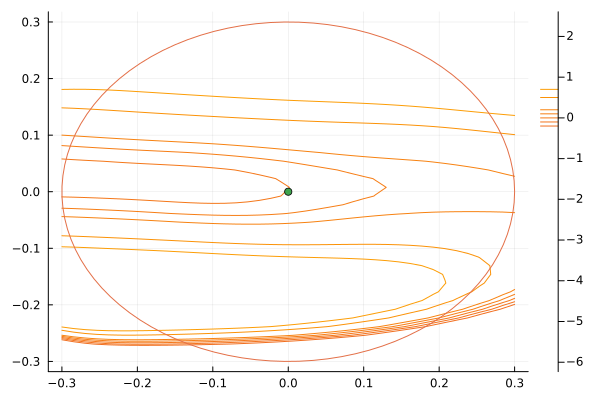

In [9]:
using Plots
x1s = x2s = range(-0.3, stop = 0.3, length = 40)
ϕs = ϕ_opt.(x1s', x2s)
contour(x1s, x2s, ϕs, levels=[-0.2, -0.1, 0, 0.1, 0.2, 0.5, 0.7])
θ = range(0, stop = 2π, length = 100)
plot!(r * cos.(θ), r * sin.(θ), label = "")
scatter!([0], [0], label = "")

We can compute the Laplace average as follows:

In [10]:
using DifferentialEquations
function S(t, x1, x2, solver = DifferentialEquations.Tsit5())
    tspan = (0.0, t)
    prob = DifferentialEquations.ODEProblem((v, p, t) -> [f(x => v) for f in F], [x1, x2], tspan)
    traj = DifferentialEquations.solve(prob, solver, reltol=1e-4, abstol=1e-4)
    return traj[end]
end

using QuadGK
function laplace_average(f, λ, x1, x2, T = 10, args...)
    v, _ = quadgk(0, T, rtol=1e-3) do t
        s = S(t, x1, x2, args...)
        return f(S(t, x1, x2, args...)) * exp(-λ * t)
    end
    return v / T
end

lap(x1, x2) = laplace_average(v -> ϕ_opt(x => v), λ, x1, x2, 10)
laplace = lap.(x1s', x2s)

40×40 Matrix{Float64}:
 -0.546685   -0.538202   -0.531168   …  70.696     116.17       186.142
  0.0158968   0.0201149   0.0231457      7.40349    14.2155      26.4282
  0.429645    0.430576    0.430538       0.177559    0.928426     2.45537
  0.720012    0.718361    0.715974      -0.250838   -0.233108    -0.114752
  0.913404    0.909806    0.905575      -0.046681   -0.105461    -0.15304
  1.0296      1.02446     1.0188     …   0.143175    0.0844104    0.0251911
  1.08404     1.07775     1.07102        0.269444    0.218264     0.165488
  1.08955     1.08243     1.07493        0.341974    0.298075     0.252798
  1.05694     1.04928     1.04128        0.373285    0.335777     0.297249
  0.995421    0.987458    0.979206       0.373841    0.342007     0.309439
  ⋮                                  ⋱                          
  0.400566    0.404884    0.409333       0.678546    0.691708     0.705355
  0.493522    0.497918    0.502453       0.775827    0.788943     0.802522
  0.590844    0.59

The error is given by:

In [11]:
norm(laplace - ϕs)

251.71534869554444

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*